#### Summary:
In this notebook I will test running FINRICH on different sets of linked cREs, to test for enrichment of GWAS variants. In this case we have credible sets for 6 traits (T1D, T2D, fasting glucose, fasting insulin, 2h glucose, and HbA1c). You can use any credible sets you'd like though!

# 1. Basic Preparation

In [1]:
# Import necessary libraries
suppressMessages(library(dplyr))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(grid))

suppressMessages(library(tictoc))
suppressMessages(library(UpSetR))
suppressMessages(library(ggplot2))
#suppressMessages(library(cicero))
#suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))

suppressMessages(library(parallel))

In [2]:
# Define celltypes list
celltypes <- c('beta','alpha','delta','gamma','ductal','acinar')

# Define colors for each celltype (same order as celltypes)
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B', '#F5DE6C')

In [22]:
method_colors <- c('#000000', #All 3 links (black)
            '#99C899', #ABC + Cicero (green)
            '#E8A082', #HM + Cicero (orange)
            '#999BD1', #HM + ABC (purple)
            '#E8CD4A', #Cicero (yellow)
            '#4AC3E8', #ABC (blue)
            '#E773B9') #HM (pink)

link_methods <- c('hm_abc_cic','abc_cic','hm_cic','hm_abc','cic','abc','hm')
names(method_colors) <- link_methods

In [4]:
distance_bins <- c('250000-1000000', '100000-250000', '50000-100000', '10000-50000', '0-10000')

In [5]:
# disable scientific notation for the filepath names of larger distances
options(scipen = 999)
set.seed(8)

### Important file paths

In [6]:
#significant links are in one file now
# sig links (w header) = links_dir + celltype + links_suffix
links_dir <- '/path/to/3methods/combined/files'
links_suffix <- '_all_methods_links.wHeader.bedpe'
bg_dir <- '/dir/with/merged/all/methods/background/links'

In [7]:
#background links are in different places 
# SMORES links (CP cut) = hm_prefix + celltype + hm_suffix
hm_prefix <- '/path/to/SMORES/background/links/'
hm_suffix <- '_all_CP_links.bedpe'

# ABC background files = abc_bg_dir + celltype + abc_bg_suffix
abc_bg_dir <- '/path/to/reprocessed/ABC/background/links/'
abc_bg_suffix <- '_nonsig_mapped_links.bedpe'

# Cicero background files = cic_bg_dir + celltype + cic_bg_suffix
cic_bg_dir <- '/path/to/reprocessed/Cicero/background/links'
cic_bg_suffix <- '_links.final_filt.bedpe'

In [8]:
peak_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/recluster_final_majorCTs_v2'

In [9]:
#final credible set files!
credset_dir <- '/dir/with/hg38/credible/sets/'
t1d_fp <- file.path(credset_dir,'T1D_Chiou_2021_cred_set.bed')
t2d_fp <- file.path(credset_dir,'T2D_DIAMANTE_multiancestry.cred99.hg38.bed')
glu2h_fp <- file.path(credset_dir,'2hGlu_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
fg_fp <- file.path(credset_dir,'FG_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
fi_fp <- file.path(credset_dir,'FI_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
hba1c_fp <- file.path(credset_dir,'HbA1c_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')

In [10]:
gwas_prefixes <- c('T1D','T2D','2hGlu','FG','FI','HbA1c')
gwas_fps <- c(t1d_fp, t2d_fp, glu2h_fp, fg_fp, fi_fp, hba1c_fp)
names(gwas_fps) <- gwas_prefixes

In [11]:
outdir <- '/dir/to/write/outputs/to'

# 1. FINRICH Prereqs:

Install finrich: `pip3 install finrich` (https://pypi.org/project/finrich/)

FINRICH inputs:
- finemapped variants bed file
- background.txt (bed file of peaks, tab separated, 3 cols)
- signal.txt (bed file of peaks, tab separated, 3 cols)

## Check the overlap of cRE sets and credible sets
It's important to do this, because if there's no overlap FINRICH won't run or produce meaningful results.

In [12]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
check_overlap <- function(finemap_bed, bed_fp, log_fp){
    system(sprintf('echo %s >> %s', bed_fp, log_fp))
    cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb | wc -l >> %s', bed_fp, finemap_bed, log_fp)
    system(cmd)
}

In [13]:
log_dir <- file.path(outdir,'credset_overlaps')
dir.create(log_dir, showWarnings=FALSE)

## Check overall overlap between cell type peak calls and credible sets

In [14]:
for (celltype in celltypes){
    ct_peaks <- file.path(peak_dir, 'ct_peaks', sprintf('%s_peaks.bed',celltype))
    log1 <- file.path(log_dir,'all_ct_peaks.T1D_overlap.txt')
    check_overlap(t1d_fp, ct_peaks, log1)
    log2 <- file.path(log_dir,'all_ct_peaks.T2D_overlap.txt')
    check_overlap(t2d_fp, ct_peaks, log2)
}

In [15]:
for (celltype in celltypes){
    ct_peaks <- file.path(peak_dir, 'ct_peaks', sprintf('%s_peaks.bed',celltype))
    log1 <- file.path(log_dir,'all_ct_peaks.HbA1c_overlap.txt')
    check_overlap(hba1c_fp, ct_peaks, log1)
    log2 <- file.path(log_dir,'all_ct_peaks.FI_overlap.txt')
    check_overlap(fi_fp, ct_peaks, log2)
    log3 <- file.path(log_dir,'all_ct_peaks.FG_overlap.txt')
    check_overlap(fg_fp, ct_peaks, log3)
    log4 <- file.path(log_dir,'all_ct_peaks.2hGlu_overlap.txt')
    check_overlap(glu2h_fp, ct_peaks, log4)
}

## Check overall overlap between per method linked cRE calls and credible sets (T1D and T2D)

In [18]:
for (celltype in celltypes){
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)
    
    #extract method links AND remove annoying columns
    hm_links <- subset(sig_links, !is.na(hm_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    abc_links <- subset(sig_links, !is.na(abc_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    cic_links <- subset(sig_links, !is.na(cic_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)

    #write these links to temp bed files
    fp1 <- file.path(log_dir,sprintf('SMORES_%s.bed',celltype))
    write.table(hm_links, fp1, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp2 <- file.path(log_dir,sprintf('ABC_%s.bed',celltype))
    write.table(abc_links, fp2, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp3 <- file.path(log_dir,sprintf('Cicero_%s.bed',celltype))
    write.table(cic_links, fp3, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    
    #then check for overlaps
    log1 <- file.path(log_dir,'ct_linked_cREs.T1D_overlap.txt')
    check_overlap(t1d_fp, fp1, log1)
    check_overlap(t1d_fp, fp2, log1)
    check_overlap(t1d_fp, fp3, log1)
    
    log2 <- file.path(log_dir,'ct_linked_cREs.T2D_overlap.txt')
    check_overlap(t2d_fp, fp1, log2)
    check_overlap(t2d_fp, fp2, log2)
    check_overlap(t2d_fp, fp3, log2)

    #and delete temp files
    system(sprintf('rm %s %s %s',fp1,fp2,fp3))
    
}

# 2. Run FINRICH on sets of linked cREs

In [19]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
run_FINRICH <- function(finemap_bed, prefix, cre_bed, bg_bed, out_dir){
    #create overall output file
    overall_out_fp <- file.path(out_dir,'combined_results.txt')
    
    #set up finrich code
    temp_fp <- file.path(out_dir, paste0(prefix,'_temp.txt'))
    cmd <- sprintf('finrich %s %s %s --permutations 1000 --processes 2 > %s', finemap_bed, cre_bed, bg_bed, temp_fp)
    #print(cmd)
    system(cmd)

    #concat and reformat outputs slightly
    cmd2 <- sprintf('awk -v prefix=%s \'NR == 1 {print prefix "|" $0;}\' %s >> %s', prefix, temp_fp, overall_out_fp)
    system(cmd2)
    system(sprintf('rm %s',temp_fp))
}

## 2a. Run on all linked cREs

In [25]:
### Function to run FINRICH on a cell type (so I can parallelize by cell type)
run_finrich_all_links_gen <- function(celltype, gwas_prefix, gwas_fp, outdir){
    #set up file paths
    gwas_dir <- file.path(outdir, gwas_prefix)
    dir.create(gwas_dir, showWarnings=FALSE, recursive=TRUE)
    
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)
    
    #extract method links AND remove annoying columns
    hm_links <- subset(sig_links, !is.na(hm_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    abc_links <- subset(sig_links, !is.na(abc_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    cic_links <- subset(sig_links, !is.na(cic_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)

    #write these links to temp bed files
    fp1 <- file.path(outdir,sprintf('SMORES_%s.bed',celltype))
    write.table(hm_links, fp1, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp2 <- file.path(outdir,sprintf('ABC_%s.bed',celltype))
    write.table(abc_links, fp2, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp3 <- file.path(outdir,sprintf('Cicero_%s.bed',celltype))
    write.table(cic_links, fp3, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    
    #run finrich with helper function
    ct_peaks <- file.path(peak_dir, sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype))
    run_FINRICH(gwas_fp, paste('SMORES',celltype,sep='-'), fp1, ct_peaks, gwas_dir)
    run_FINRICH(gwas_fp, paste('ABC',celltype,sep='-'), fp2, ct_peaks, gwas_dir)
    run_FINRICH(gwas_fp, paste('Cicero',celltype,sep='-'), fp3, ct_peaks, gwas_dir)
    
    #and delete temp files
    #system(sprintf('rm %s %s %s',fp1,fp2,fp3))
}

In [28]:
res_dir1 <- file.path(outdir, 'all_links')
dir.create(res_dir1, showWarnings=F)

In [30]:
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(celltypes, run_finrich_all_links_gen, gwas_prefix, gwas_fp, res_dir1)
}

[1] "T1D 2024-07-02 20:39:42"
[1] "T2D 2024-07-02 20:50:10"
[1] "2hGlu 2024-07-02 20:53:29"
[1] "FG 2024-07-02 20:54:37"
[1] "FI 2024-07-02 20:56:14"
[1] "HbA1c 2024-07-02 20:57:33"


## 2b. Run on all sets of method overlaps

In [31]:
### Function to run FINRICH on a cell type (so I can parallelize by cell type)
### slightly modified to run for method overlap link sets
run_finrich_method_overlaps_gen <- function(celltype, gwas_prefix, gwas_fp, outdir){
    #set up file paths
    gwas_dir <- file.path(outdir, gwas_prefix)
    dir.create(gwas_dir, showWarnings=FALSE, recursive=TRUE)
    
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)
    
    #extract each overlap set and run FINRICH separately
    for(set in link_sets){
        #extract links and write to temp bed file
        sig_links_cut <- subset(sig_links, method_str==set) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
        fp <- file.path(outdir, sprintf('%s_%s.bed',celltype,set))
        write.table(sig_links_cut, fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    
        #run finrich with helper function
        ct_peaks <- file.path(peak_dir, sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype))
        run_FINRICH(gwas_fp, paste(set,celltype,sep='-'), fp, ct_peaks, gwas_dir)

        #delete temp file
        system(sprintf('rm %s',fp))
    }
}

In [32]:
res_dir2 <- file.path(outdir, 'method_overlaps')
dir.create(res_dir2, showWarnings=F)

In [33]:
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(celltypes, run_finrich_method_overlaps_gen, gwas_prefix, gwas_fp, res_dir2)
}

[1] "T1D 2024-07-02 20:59:08"
[1] "T2D 2024-07-02 21:23:41"
[1] "2hGlu 2024-07-02 21:30:03"
[1] "FG 2024-07-02 21:31:38"
[1] "FI 2024-07-02 21:34:25"
[1] "HbA1c 2024-07-02 21:36:19"


# Plot interesting outputs - Ex: T2D and fasting glucose

In [12]:
finrich_outdir <- outdir

In [23]:
label_map <- c('SMORES-ABC-Cicero','ABC-Cicero','SMORES-Cicero','SMORES-ABC','Cicero','ABC','SMORES')
names(label_map) <- link_methods
label_map

hm_abc_cic             abc_cic              hm_cic              hm_abc 
"SMORES-ABC-Cicero"        "ABC-Cicero"     "SMORES-Cicero"        "SMORES-ABC" 
                cic                 abc                  hm 
           "Cicero"               "ABC"            "SMORES"

In [24]:
label_order <- paste(label_map, rep(c('T2D','MAGIC_FG'),each=7))

In [33]:
colors2 <- copy(method_colors)
names(colors2) <- label_map
colors2

SMORES-ABC-Cicero        ABC-Cicero     SMORES-Cicero        SMORES-ABC 
        "#000000"         "#99C899"         "#E8A082"         "#999BD1" 
           Cicero               ABC            SMORES 
        "#E8CD4A"         "#4AC3E8"         "#E773B9"

In [35]:
#example for one cell types
indir <- file.path(finrich_outdir, 'method_overlaps')
ct <- 'beta'
sig_cutoff=0.1

# FIRST READ IN FG RESULTS
fp1 <- file.path(indir, 'MAGIC_FG', 'combined_results_reformat.txt')
data1 <- read.table(fp1, sep='\t', header = TRUE)
data1 <- data1 %>% subset(celltype==ct)
data1$qval <- p.adjust(data1$pval, method='BH')

# Sort data_cut by celltype (use to refactor later on) -- maybe don't do this
data_cut_sort1 <- data1[order(data1$method, data1$celltype),]
data_cut_sort1$sig <- ifelse(data_cut_sort1$qval < sig_cutoff, '*', '')
data_cut_sort1$gwas <- 'FG'

# THEN READ IN T2D RESULTS
fp2 <- file.path(indir, 'T2D', 'combined_results_reformat.txt')
data2 <- read.table(fp2, sep='\t', header = TRUE)
data2 <- data2 %>% subset(celltype==ct)
data2$qval <- p.adjust(data2$pval, method='BH')

# Sort data_cut by celltype (use to refactor later on) -- maybe don't do this
data_cut_sort2 <- data2[order(data2$method, data2$celltype),]
data_cut_sort2$sig <- ifelse(data_cut_sort2$qval < sig_cutoff, '*', '')
data_cut_sort2$gwas <- 'T2D'

In [36]:
# MERGE INTO ONE DF
data <- rbind(data_cut_sort1,data_cut_sort2)

#Prepare strings for y-labels (get rid of underscore in rownames)
data$y_labels <- paste(plyr::mapvalues(x=data$method, from=names(label_map), to=label_map),data$gwas, sep=' ')
data$link_set <- plyr::mapvalues(x=data$method, from=names(label_map), to=label_map)
data$color <- colors2[data$link_set] 
xmax <- ceiling(max(data$fold_enrich) + 0.5)
xmax

[1] 9

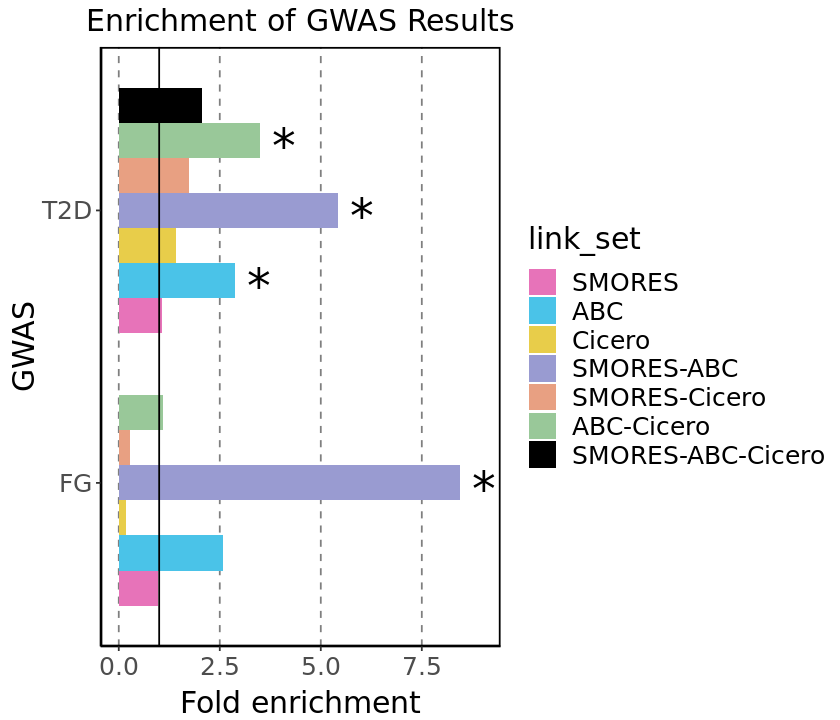

In [37]:
# Make a bar plot with the subsetted data
options(repr.plot.width = 7, repr.plot.height = 6)
theme_set(
    theme_classic())

p1 <- ggplot(data=data, aes(x=fold_enrich, y=gwas, fill=link_set)) + 
        geom_vline(xintercept=seq(0, xmax, 2.5), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
        geom_bar(position=position_dodge(0.9), stat='identity') + 
        scale_fill_manual(values=colors2) + 
        geom_vline(xintercept=1, color='black', size=0.5) + 
        geom_text(aes(fold_enrich, gwas, label=sig), size=10, position=position_dodge(0.9), hjust=-0.5, vjust=0.65) +
        xlim(0,xmax) + 
        xlab('Fold enrichment') + ylab('GWAS') + labs(title='Enrichment of GWAS Results') + 
        theme(plot.title=element_text(size=18, hjust=0.5),
              axis.text.x=element_text(size=15, vjust=0.5),
              axis.text.y=element_text(size=15, vjust=0.5),
              axis.title.x = element_text(size=18, vjust=-0.35),
              axis.title.y = element_text(size=18, vjust=0.5),
              legend.text=element_text(size=15),
              legend.title=element_text(size=18),
              panel.border=element_rect(color='black',fill=NA, size=1))    
p1$data$link_set <- factor(x = p1$data$link_set, levels=rev(label_map))
print(p1)